In [1]:
from pathlib import Path

In [2]:
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import RobustScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

We perform hierarhical clustering with complete linkage on the centroids obtained by kmeans clustering with k=10000.

In [3]:
sns.set_theme(context='notebook', style='whitegrid', palette='muted')

In [4]:
def get_linkage_matrix(model):
    # Create linkage matrix

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    return linkage_matrix

def plot_dendrogram(model, **kwargs):
    linkage_matrix = get_linkage_matrix(model)
    dendrogram(linkage_matrix, **kwargs)

In [5]:
results_dir = Path('../../results')
train = pd.read_csv(results_dir / 'train_clean.csv')
num_cols = train.dtypes[(train.dtypes == 'float64') | (train.dtypes =='int64')].index
num_cols

Index(['startYear', 'runtimeMinutes', 'numVotes', 'totalImages',
       'totalCredits', 'numRegions', 'companiesNumber', 'averageRating',
       'externalLinks', 'writerCredits', 'numGenres', 'criticReviewsRatio'],
      dtype='object')

In [6]:
train_X = RobustScaler().fit_transform(train[num_cols])

In [7]:
%%time
kmeans = KMeans(n_clusters=10000, random_state=42)
kmeans.fit(train_X)

CPU times: user 22min 5s, sys: 4.31 s, total: 22min 10s
Wall time: 3min 18s


,n_clusters,10000
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


Text(0.5, 1.0, 'Histogram for number of records in kmeans clusters')

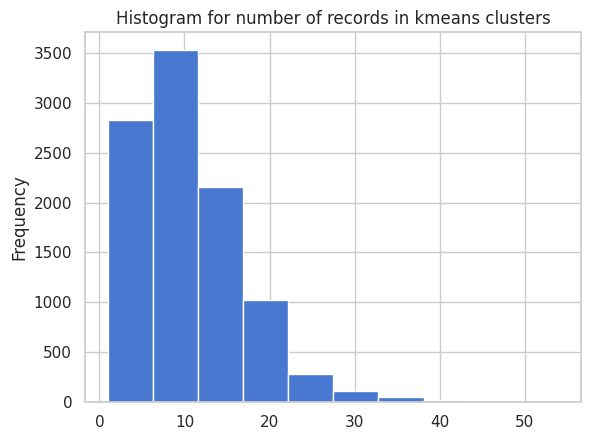

In [8]:
_, counts = np.unique(kmeans.labels_, return_counts=True)
pd.Series(counts).plot.hist()
plt.title('Histogram for number of records in kmeans clusters')

In [9]:
hier_clust = AgglomerativeClustering(
    distance_threshold=0,
    compute_distances=True,
    n_clusters=None,
    linkage='ward',
)
hier_clust.fit(kmeans.cluster_centers_)

,n_clusters,None
,metric,'euclidean'
,memory,None
,connectivity,None
,compute_full_tree,'auto'
,linkage,'ward'
,distance_threshold,0
,compute_distances,True


In [10]:
threshold = 47

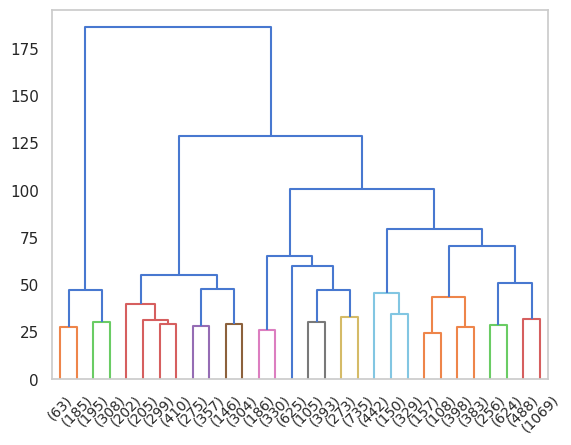

In [11]:
plot_dendrogram(hier_clust, truncate_mode='lastp', color_threshold=threshold)
plt.grid(None)

In [12]:
linkage_matrix = get_linkage_matrix(hier_clust)
labels = fcluster(linkage_matrix, criterion='distance', t=threshold)
np.unique(labels, return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13], dtype=int32),
 array([ 248,  503, 1116,  632,  450,  516,  625,  498, 1008,  921, 1046,
         880, 1557]))

In [13]:
# Map kmeans labels to hierarchical clustering labels
labels_map = {
    i: int(label)
    for i, label
    in enumerate(labels)
}

In [14]:
train['cluster'] = kmeans.labels_
train['cluster'] = train['cluster'].map(labels_map)
train['cluster'] = pd.Categorical(train['cluster'])
train['cluster'].value_counts()

cluster
13    23170
11    11729
9     11593
12    11192
10     8926
3      7712
7      6036
4      5957
6      4671
8      4370
2      3923
5      3717
1      1668
Name: count, dtype: int64

In [15]:
avengers = train.loc[16857]
pulp_fiction = train.loc[76320]
bcs = train.loc[73573]


Text(3.828641396489095, 13.430885773852903, 'Better Call Saul')

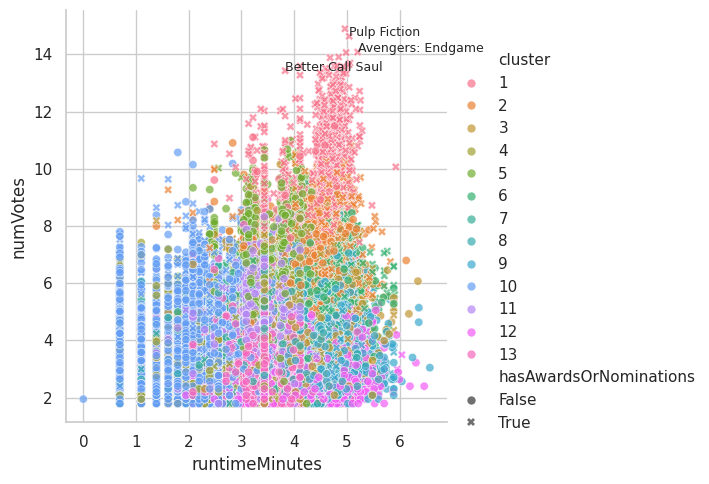

In [16]:
g = sns.relplot(train, x='runtimeMinutes', y='numVotes', hue='cluster',
                style='hasAwardsOrNominations', alpha=.7)
g.ax.annotate(avengers['originalTitle'], xy=(avengers['runtimeMinutes'], avengers['numVotes']), fontsize=9)
g.ax.annotate(pulp_fiction['originalTitle'], xy=(pulp_fiction['runtimeMinutes'], pulp_fiction['numVotes']), fontsize=9)
g.ax.annotate(bcs['originalTitle'], xy=(bcs['runtimeMinutes'], bcs['numVotes']), fontsize=9)

In [17]:
bool_cols = train.dtypes[train.dtypes == 'bool'].index

In [18]:
by_cluster = train.groupby('cluster')
by_cluster[bool_cols].sum() / by_cluster[bool_cols].count()

/tmp/ipykernel_10595/2276869571.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_cluster = train.groupby('cluster')


,canHaveEpisodes,hasAwards,hasAwardsOrNominations,hasVideos,hasCriticsReviews,hasUserReviews,moreDirectorsCredits,hasQuotes,moreCountriesOfOrigin
cluster,,,,,,,,,
1,0.247002,0.570144,0.796163,0.871703,0.976619,0.996403,0.055755,0.724820,0.308753
2,0.102473,0.303849,0.448891,0.452715,0.904410,0.970941,0.079531,0.457303,0.185317
3,0.231328,0.157028,0.235088,0.151452,0.318076,0.485737,0.081821,0.079746,0.066909
4,0.085110,0.104247,0.142186,0.054726,0.208494,0.380896,0.095350,0.182474,0.026859
5,0.011568,0.013990,0.022330,0.126715,0.550175,0.634383,0.136938,0.495292,0.048964
6,0.038322,0.192892,0.287733,0.137230,0.751873,0.853779,0.076429,0.194605,0.170627
7,0.083665,0.048708,0.071405,0.024354,0.104042,0.155732,0.119947,0.036945,0.028661
8,0.111213,0.050801,0.089931,0.063387,0.189931,0.303204,0.067506,0.028375,0.034554
9,0.035194,0.115846,0.180540,0.049081,0.268610,0.430087,0.087208,0.053739,0.070905


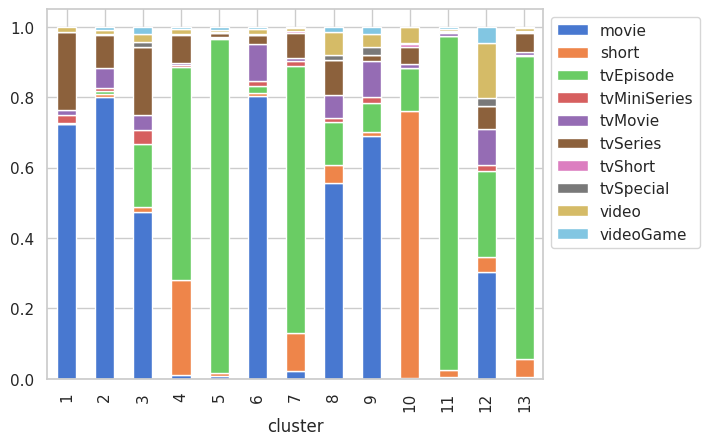

In [19]:
titletype_by_cluster = pd.crosstab(train['cluster'], train['titleType'])
titletype_by_cluster.div(titletype_by_cluster.sum(1), axis=0).plot(kind='bar', stacked=True)
legend = plt.legend(
    bbox_to_anchor=(1, 1),
)

Cluster 1 and 2 (that are merged at a higher threshold) are made up primarily from movies (with some tv series).
These clusters probably contain blockbuster movies and very popular TV series. Almost 57% of records from cluster 1 received awards, a proportion that increases to 80% when considering also nominations.

In [26]:
train[['cluster']].to_csv(results_dir / 'clustering.csv', index=False)